In [1]:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
import re
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql import SQLContext
import nltk
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
stopwords=text.ENGLISH_STOP_WORDS
DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/data/'
#DATAFILEPATH='C:/Users/balachandrd/Documents/Personal/CS-109/Project/project_cs109/data/'

In [25]:
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
stopwords=text.ENGLISH_STOP_WORDS

#Since we are looking for only nouns, we want to avoid parsing for most popular words such as 'bike' and 'bicycle'
CUSTOM_STOPWORDS_NOUN=['bike', 'bicycle']
CUSTOM_STOPWORDS=['']


In [3]:
bike_masterdf = pd.read_csv(DATAFILEPATH+'bike_details.csv',encoding='utf-8')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
0,0,50088,Schwinn Gateway,absent,Schwinn,Gateway,NaN,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-07-06 22:27:01,2015-11-03 05:36:54,https://bikeindex.org/bikes/50088,https://bikeindex.org/api/v1/bikes/50088,117,NaN,NaN,NaN,NaN,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1436221621,1446529014,0
1,1,60140,2016 Specialized Diverge Elite DSW,WSBC601010269K,Specialized,Diverge Elite DSW,2016,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-10-08 19:18:50,2015-11-03 05:34:30,https://bikeindex.org/bikes/60140,https://bikeindex.org/api/v1/bikes/60140,307,NaN,NaN,52cm,NaN,True,NaN,Bike,False,NaN,NaN,NaN,aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1444331930,1446528870,0


In [20]:
#Peek at theft description

print (bike_subdf.theft_description[0:15])


3                                             bike rack
4                             car bike rack Reward: $75
5                      Backyard Reward: I have no money
6                              Open Garage Reward: $300
7     15\\" thick steel hand railing to which my bik...
8                              Powell Park Reward: $100
9                 PCC SE Campus at SE 82nd and Division
10                                         Reward: $150
11    A bike rack. Reward: A BIG HUG, MAYBE MONEY TO...
14                                         McDonald\\'s
15                                bike rack Reward: 200
16                                bike rack Reward: 200
17                              se 19th and se brooklyn
18    2131 NE 11th Ave Portland, OROut of my garage ...
19                         Outside of 120 NW Trinity Pl
Name: theft_description, dtype: object


### Taking a peek

From the above excerpt of theft description, we can already see that some descriptions are almost too abrupt and to the point e.g. bike rack, thereby relaying very little information other than where the bike was prior to theft. Some  descriptions detail on how the bike was secured prior to theft and other descriptions talk about renumerations. There definitely is a lot of text cleaning that is required. 

In [21]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf1 = bike_masterdf[~desc_mask]
desc_mask2 = bike_subdf1.theft_description == ' '
bike_subdf = bike_subdf1[~desc_mask2]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

bike_subdf.to_csv(DATAFILEPATH+'stolen_bikes.csv',encoding='utf-8')
bike_subdf.head(20)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen:  0.56
Number of Stolen bikes with theft description: 28728


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828
5,5,11540,Motobecane Fantom Cross (pro?),absent,Motobecane,Fantom Cross (pro?),NaN,https://files.bikeindex.org/uploads/Pu/4383/sm...,https://files.bikeindex.org/uploads/Pu/4383/la...,False,True,"Portland, OR, 97202",2013-08-20 06:00:00,2013-08-20 06:00:00,2015-11-03 05:10:30,https://bikeindex.org/bikes/11540,https://bikeindex.org/api/v1/bikes/11540,234,NaN,NaN,NaN,"I'm not sure the size but I'm 6'0"" and the bik...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7887,1376978400,"Portland, OR, 97202",45.489360,-122.652139,Backyard Reward: I have no money,NaN,NaN,NaN,NaN,2014-06-14 17:52:46,False,"4546 SE McLoughlin Blvd, Portland, OR 97202, USA",4546,Southeast McLoughlin Boulevard,97202,Brooklyn,Portland,Multnomah County,Oregon,United States,1376978400,1376978400,1446527430,1402768366
6,6,11541,2007 Trek 7.3 FX WSD,WTU345C2237B,Trek,7.3 FX WSD,2007,NaN,NaN,False,True,"Berkeley, CA, 94709",2009-08-29 06:00:00,2009-09-15 06:00:00,2015-11-03 05:19:08,https://bikeindex.org/bikes/11541,https://bikeindex.org/api/v1/bikes/11541,47,NaN,NaN,15in,Black shiny lady's Trek with custom handlebars...,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7888,1251525600,"Berkeley, CA, 94709",37.876292,-122.273896,Open Garage Reward: $300,NaN,NaN,09-49953,Berkeley,2014-06-14 17:52:49,False,"1843 Virginia St, Berkeley, CA 94703, USA",1843,Virginia Street,94703,North Berkeley,Berkeley,Alameda County,California,United States,1251525600,1252994400,1446527948,1402768369
7,7,11546,2009 Trek 4300,WTU364C1402D,Trek,4300,2009,https://bikebook.s3.amazonaws.com/uploads/Fr/1...,https://bikebook.s3.amazonaws.com/uploads/Fr/1...,True,True,"Washington, DC, 20037",2009-09-07 06:00:00,2009-09-16 06:00:00,2015-11-03 05:19:06,https://bikeindex.org/bik

Theft description with maximum word count: 558
Theft description with minimum word cunt:  1
Average word count of description: 10.61


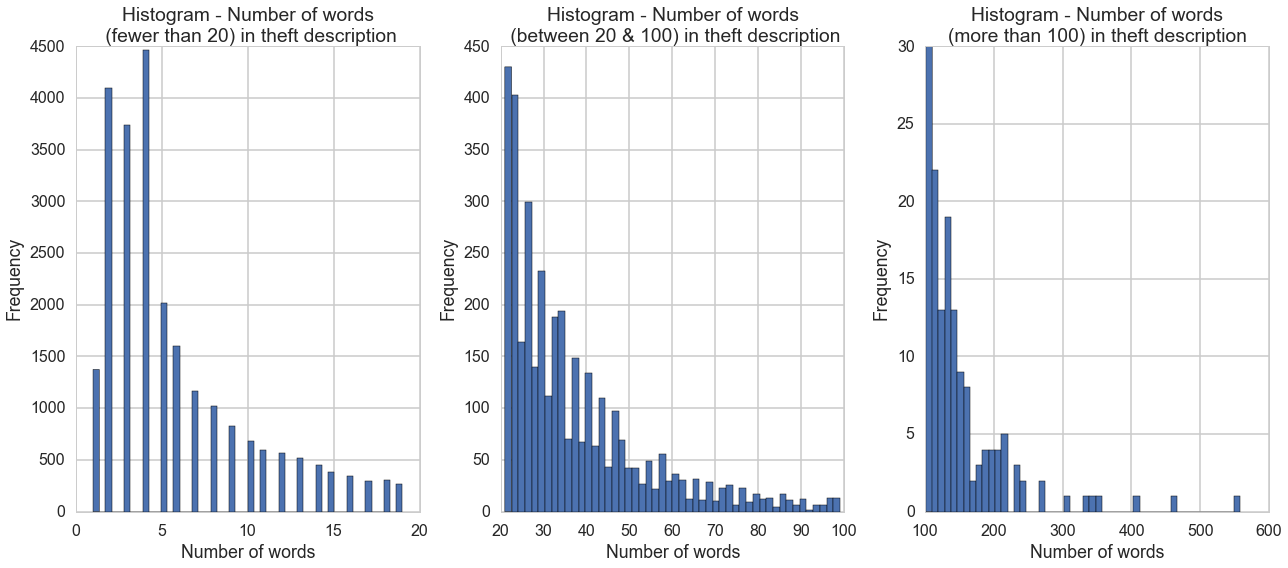

In [36]:
#Peek at the description data - Basic exploratory analysis

# Split each theft description to number of words to get an idea of how long the descriptions are
# exploratory
theft_desc_word_count = bike_subdf.theft_description.apply(lambda x: len(x.split()))


print "Theft description with maximum word count:", max(theft_desc_word_count)
print "Theft description with minimum word cunt: ", min(theft_desc_word_count)
print "Average word count of description: %.2f" % np.mean(theft_desc_word_count)
theft_desc_word_count_small = theft_desc_word_count[theft_desc_word_count < 20]
theft_desc_word_count_mid = theft_desc_word_count[(theft_desc_word_count > 20) & (theft_desc_word_count < 100)]
theft_desc_word_count_large = theft_desc_word_count[theft_desc_word_count > 100]
#theft_desc_word_count_small.tolist

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), tight_layout=True)
ax1.hist(theft_desc_word_count_small.tolist(), bins=50,histtype='bar' )
ax1.set_title('Histogram - Number of words \n (fewer than 20) in theft description')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Frequency')
ax2.hist(theft_desc_word_count_mid.tolist(), bins=50,histtype='bar' )
ax2.set_title('Histogram - Number of words \n (between 20 & 100) in theft description')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Frequency')
ax3.hist(theft_desc_word_count_large.tolist(), bins=50,histtype='bar' )
ax3.set_title('Histogram - Number of words \n(more than 100) in theft description')
ax3.set_xlabel('Number of words')
ax3.set_ylabel('Frequency')

### Theft description as a bunch of words

The sentences in theft description were split in to individual words to get an understanding of the amount of effort put by the bike owners in to describing the theft. The average number of words per description is about 10-11 where as there are exceptions with 558 as being the maximum and some with as very little as 1. 

The above histogram gives an idea of the text distribution. A large number of theft descriptions are fewer than 5 words, with 2 and 4 words per description being the most common. There is a substantial dip in the number theft descriptions with 20 to 100 words. The dip is seen once again past the 100 word mark. 

This goes to show that bike owners typically take less interest in detailing the theft while submitting information about theft. It also could be that those who chose to write fewer words possibly had less expensive bikes vs those who chose to write more than 100 words. Those who wrote detailed descriptions possibly had expensive bikes and wanted to give as much information as possible or are really thorough in their work.

In [23]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

def gather_nouns(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    nouns=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN', 'NNS']:
                    if token[4] in CUSTOM_STOPWORDS_NOUN or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    nouns2=[]

    for n in nouns:
        if len(n)!=0:
            nouns2.append(n)
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(nouns2)


def gather_nouns_and_adj(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    tokens=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN','NNS','NNP','JJ','JJR','JJS' ]:
                    if token[4] in CUSTOM_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    
                    #print token[4]    
                    tokens.append(token[4])
    tokens2=[]

    for n in tokens:
        if len(n)!=0:
            tokens2.append(n)
            # Remove repeating bigrams (e.g bike bike)
            if (len(tokens2) !=1):
                if (tokens2[-1] == tokens2[-2]):
                    tokens2.pop()
            
            
                            
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(tokens2)

In [27]:
# Test parsing functions to understand if parsing will be fine
# Following sentence was constructed on the fly and does not belong to the BikeIndex data

atext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike was of make 'GT' with shimano \
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike. My counsin' bike was \
stolen from their home's open garage overnight reward"

print gather_nouns(atext)
print "\n"
print gather_nouns_and_adj(atext)
print "\n"




sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimano gear custom seat apartment security office chance counsin home garage reward


bike sign pole apartment corner superstore lock combination lock helmet bike good security block apartment bike make gt shimano gear custom seat apartment security office chance bike counsin bike home open garage overnight reward




### Parse Nouns
Theft description data takes on a broad spectrum when it comes to context. Each owner posting theft description has their own style, can decide to be very specific or elaborate about the theft, could decide to focus on location of theft and describing the bike itself or could describe the circumstances yielding to the bike theft. Given that theft description can be approached from multiple angles, we shall start with gathering only the nouns from the description. The nouns will give an idea of 'what', 'where'. We are not really interested in the 'when'. If the data provided to us the 'Who' and 'Why', then the investigation could assume a different angle. 

In this discussion, we shall only focus on the 'what' and 'where'. Note that 'where' is already available in terms if 'location/city/coordinates' in the data. However, the 'where' here will be focussing on the type of property and its specifics.  

Note: As part of the stop words used for parsing the text, the words 'bike' and 'bicycle' were added to the stop words to avoid cluttering the parsed words with redundant information. This is only applicable if we are parsing for single words and NOT for bigrams or when looking for adjectives that may describe the theft.

In [38]:
# Parse Theft description for Nouns 
# Clean resulting data frame to remove null entries where no nouns were parsed from theft description
# Apply gather_nouns function, convert to dataframe and attach to original data frame for storing to file

noun_parsed = bike_subdf.theft_description.map(gather_nouns)

noun_parsed = noun_parsed.to_frame()

noun_parsed.columns = ['theft_desc_nouns']


#Merge new dataframe with original
newdf = pd.concat([bike_subdf, noun_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask = newdf.theft_desc_nouns == ''
bike_df_clean = newdf[~null_mask].copy()
bike_df_clean['theft_desc_nouns'].head(10)

3                          rack
4               car rack reward
5         backyard reward money
6                 garage reward
7     steel hand railing u-lock
8            powell park reward
9               campus division
10                       reward
11        rack reward hug money
14                     mcdonald
Name: theft_desc_nouns, dtype: object

In [40]:
#Tokenize each theft description to return a list of nouns (ONLY)
# We will remove words whose word count is less than 2
# We will also provide max_features parameter to vectorizer to only account for top 200 features as we are only 
# trying to peek that the word count before any analysis

vectorizer_TRIM = CountVectorizer(min_df=2, stop_words='english', max_features=200)
text_sparse_matrix_TRIM = vectorizer_TRIM.fit_transform(bike_df_clean.theft_desc_nouns)

In [42]:
# From vectorizer, gather word-frequency data to look for highy frequency words
#Credit: http://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-scikit

Nouns = vectorizer_TRIM.get_feature_names()
Noun_Counts = np.asarray(text_sparse_matrix_TRIM.sum(axis=0)).ravel()
Nouns_Freq = pd.DataFrame({'Nouns': Nouns, 'Count':Noun_Counts})
Sorted_Nouns_Freq = Nouns_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Freq.to_csv(DATAFILEPATH+'Nouns_top200_frequency.csv')

### Nouns

Prior to doing any more analysis, we need to understand the frequency of the nouns in the descriptions. Given that the nouns will be descibing the 'what' and 'where' of the theft, we can expect a select set of words to be highly frequent among theft descriptions. Some of these words may make sense and other may not. At the same time, there will be a lot of words that may not be relevant to point of this investigation ('where').  As there can only be a handful of popular locations/points from which a bicycle can be stolen, we can preset this number temporarily to less than 100 and explore the data. Following graph, shows the top 90 words in the dataset.

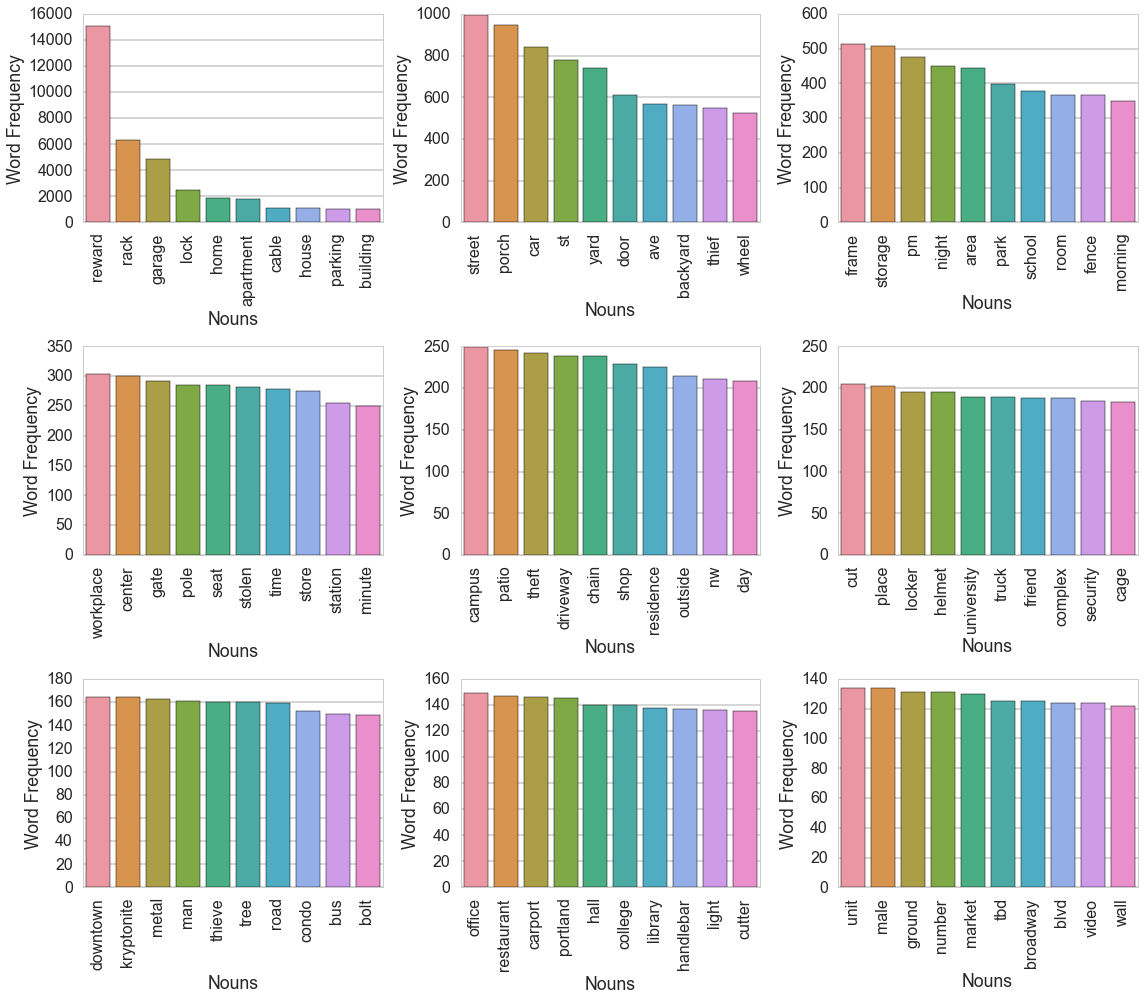

In [44]:
# Plot bar graph of Frequency of top 200 words that were vectorized 
#

nrows=3
ncols=3
plt_rows = np.arange(nrows)
plt_cols = np.arange(ncols)
f1, ax1 = plt.subplots(figsize=(16,14), nrows=nrows, ncols=ncols)
f1.set_tight_layout(True)
x = 0
#sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[0:10])
for row in plt_rows:
    for col in plt_cols:
        a = sns.barplot(x='Nouns',y='Count',data= Sorted_Nouns_Freq[x:x+10], ax=ax1[row][col])
        #print row,col
        a.set_xticklabels(Sorted_Nouns_Freq['Nouns'][x:x+10].tolist(), rotation='vertical')
        a.set_ylabel('Word Frequency')
        x+=10
    x+=10



### 